### importing fastai



In [1]:
from fastai.vision import * 

### Let's download the data

In [3]:
path = untar_data('	https://s3.amazonaws.com/fast-ai-imageclas/imagewoof-320') 

#### Since the imagewoof dataset has label codes instead of label names, we will have to map them to their respective names

In [4]:
lbl_dict = dict(
  n02093754='Australian terrier', 
  n02089973='Border terrier', 
  n02099601='Samoyed', 
  n02087394='Beagle', 
  n02105641='Shih-Tzu', 
  n02096294='English foxhound', 
  n02088364='Rhodesian ridgeback', 
  n02115641='Dingo', 
  n02111889='Golden retriever', 
  n02086240='Old English sheepdog'
) #created a dictionary to map codes to names

def lbl_trfm(o): #function that maps given code to class name
  return lbl_dict[str(o).split('/')[-2]]

### Applying image transforms and data augmentation

In [5]:
tfms = get_transforms()
tfms  # a bunch of small random transformations for better generalization

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [6]:
data = (ImageList.from_folder(path)  #the imagewoof dataset already has the val set labelled so we don't have to split the data
        .split_by_folder(valid='val')
        .label_from_func(lbl_trfm)  ## converting codes to names
        .transform(tfms, size=160)  ## applying the transforms above and resizing the 320 x 320 images to 160 x 160
        .databunch(bs=32)  # set batch size to 32
        .normalize(imagenet_stats)) # normalize the image according to imagenet stats


#### Let's look at the data

In [7]:
data

ImageDataBunch;

Train: LabelList (12454 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
Australian terrier,Australian terrier,Australian terrier,Australian terrier,Australian terrier
Path: /root/.fastai/data/imagewoof-320;

Valid: LabelList (500 items)
x: ImageList
Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160),Image (3, 160, 160)
y: CategoryList
Australian terrier,Australian terrier,Australian terrier,Australian terrier,Australian terrier
Path: /root/.fastai/data/imagewoof-320;

Test: None

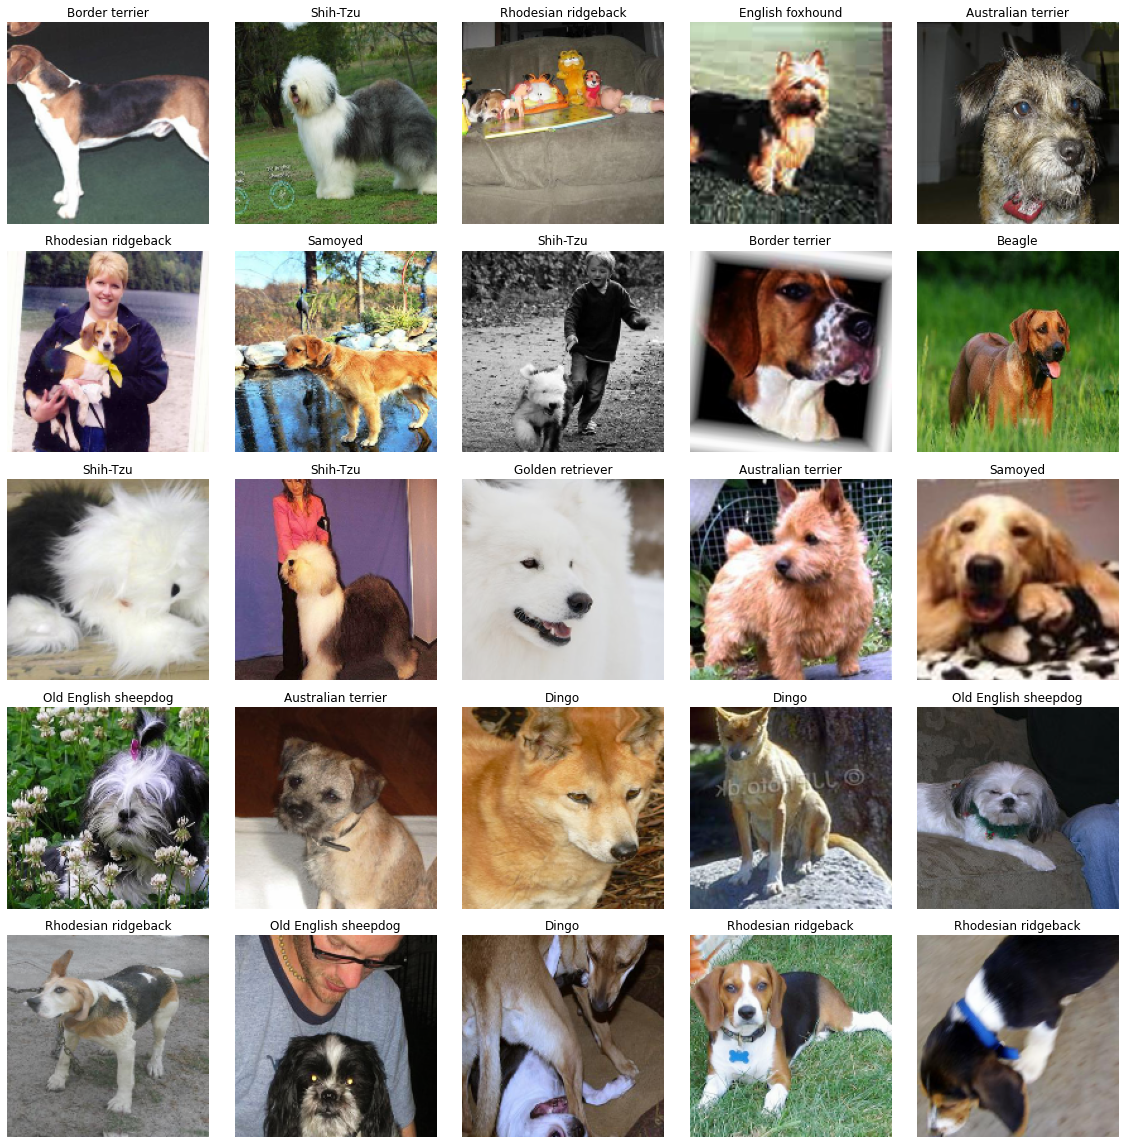

In [8]:
data.show_batch(5, figsize=(16,16))

#### since we have to use a pretrained resnet 34 architecture with discriminative learning rates

In [10]:
learn = cnn_learner(data, models.resnet34, pretrained=True, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


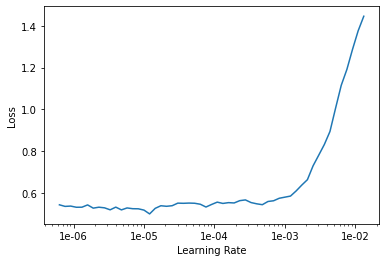

In [13]:
learn.lr_find()  ##finding an ideal learning rate
learn.recorder.plot()

In [14]:
learn.unfreeze()

In [15]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-2)) ## number of epochs = 10, learning rate sliced

epoch,train_loss,valid_loss,accuracy,time
0,0.537391,0.461915,0.856000,01:35
1,0.618030,0.478532,0.856000,01:35
2,0.497961,0.386842,0.864000,01:35
3,0.397134,0.394928,0.870000,01:36
4,0.351840,0.338609,0.886000,01:35
5,0.241651,0.439086,0.886000,01:35
6,0.176338,0.358084,0.896000,01:35
7,0.104367,0.357202,0.902000,01:37
8,0.091900,0.433769,0.904000,01:36
9,0.083682,0.397019,0.900000,01:35


#### learning rate variation

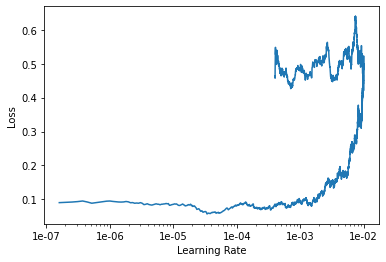

In [17]:
learn.recorder.plot()

### Result

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

#### Confusion Matrix

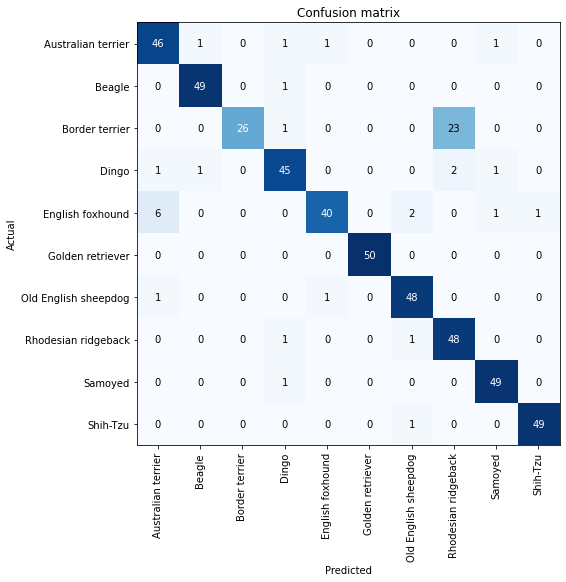

In [20]:
interp.plot_confusion_matrix(figsize=(8,8))

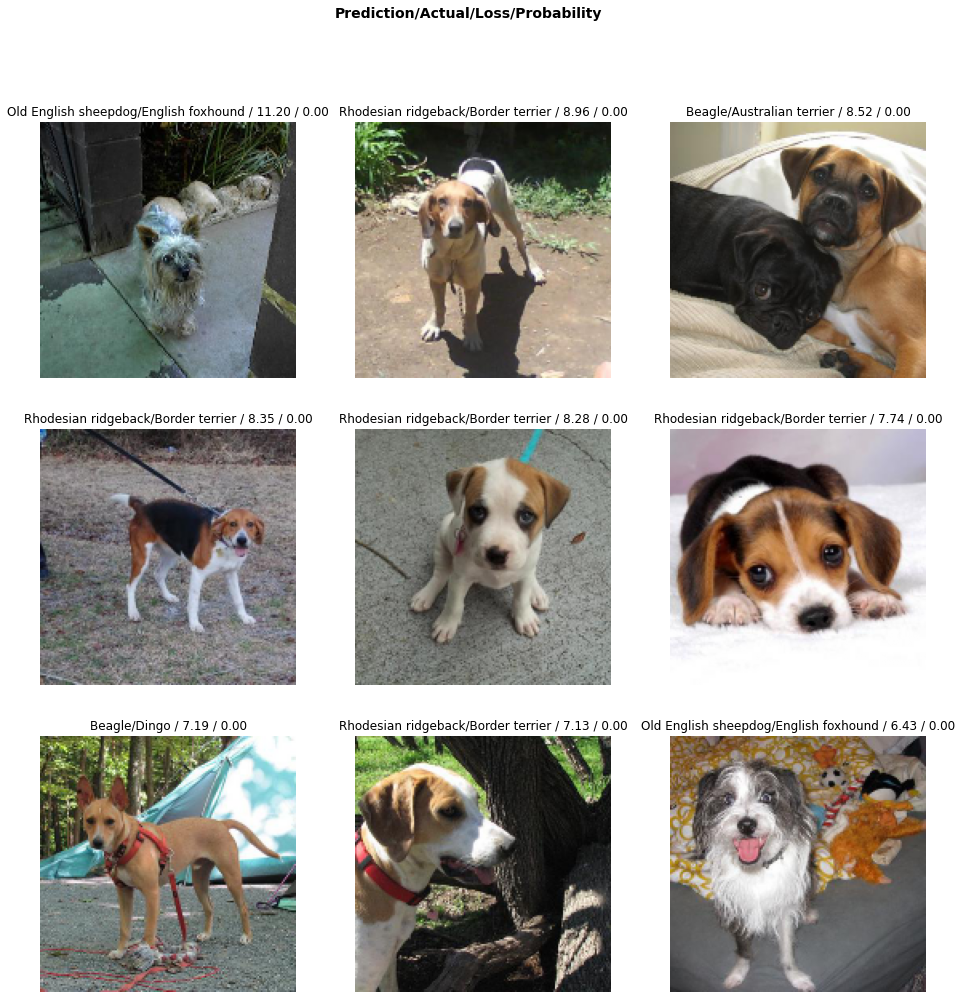

In [21]:
interp.plot_top_losses(9, figsize=(16,16))

#### We managed to get an accuracy of >90% with some overfitting